In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors

import re
import phik
from umap import UMAP

from IPython.display import clear_output
from multiprocessing import Pool

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor

import shap
from boruta import BorutaPy
import os
import phik

In [3]:
from rdkit.Chem import AllChem, DataStructs

In [4]:
from joblib import dump, load
fpps_good = load('../model_features/fpps_good.joblib') 
mcf7_good = load('../model_features/mcf7_good.joblib') 
pc3_good = load('../model_features/pc3_good.joblib') 

def get_descr_value(molecule, descr_func):
    out_arr = np.zeros((1,), dtype=int)
    descriptor = descr_func(molecule)
    if isinstance(descriptor, rdkit.DataStructs.cDataStructs.ExplicitBitVect):
        DataStructs.ConvertToNumpyArray(descriptor, out_arr)
        return out_arr
    return descriptor

def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    df = calc.pandas(mols, quiet=True, nproc=1)
    return df

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        mol=Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors, desc_names   

def get_clust_df(df, good_col):
    mols = [Chem.MolFromSmiles(smile) for smile in df['smiles']]
    fps = []
    col = [f'mor_{i}' for i in range(1024)]
    col.extend([f'mac_{i}' for i in range(167)])
    df_clust = df.copy()
    
    # mor+mac
    for i in range(len(mols)):
        mac = get_descr_value(mols[i], AllChem.GetMACCSKeysFingerprint)
        mor = np.array(AllChem.GetMorganFingerprintAsBitVect(mols[i], radius=3, useFeatures=False, nBits=1024))
        fps.append(np.concatenate([mor, mac]))
    fps = np.array(fps)
    
    #mordred
    mordred_descriptors = All_Mordred_descriptors(df['smiles'])
    mordred_descriptors = mordred_descriptors.drop(columns=mordred_descriptors.columns[mordred_descriptors.dtypes == object])
    mordred_descriptors = mordred_descriptors.drop(columns=mordred_descriptors.columns[mordred_descriptors.dtypes == bool])
    mordred_descriptors = mordred_descriptors.dropna(axis=1)
    
    #rdkit
    Mol_descriptors, desc_names = RDkit_descriptors(df['smiles'])
    Mol_descriptors = pd.DataFrame(Mol_descriptors)[good_col]
    Mol_descriptors.columns = [f'rdkit_{i}' for i in range(len(Mol_descriptors.columns))]
    
    df_clust = pd.concat([
        df_clust,
        pd.DataFrame(columns=col, data=fps)],
        axis=1)
    df_clust = pd.concat([df_clust, Mol_descriptors, mordred_descriptors], axis=1)
    df_clust.columns = [str(col) for col in df_clust.columns]
    return df_clust

In [5]:
np.float = np.float64

In [10]:
# df = pd.read_excel('../data/init_data/BF_all.xlsx')
df = pd.read_csv('../data/init_data/init.csv')

In [11]:
df

,Unnamed: 0,smiles,fpps,mcf7,pc3,ggpps,mol
0,21,OC(P(O)(O)=O)(CN1C2=CC=CC=C2N=C1)P(O)(O)=O,5.114481,9.881594,8.635562,10.776659,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,84,O=C1CN=C(SCC(P(O)(O)=O)(O)P(O)(O)=O)N1C,6.229116,9.237689,9.176878,11.527733,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,23,OC(P(O)(O)=O)(CN1C2=CC(OC)=CC=C2N=C1)P(O)(O)=O,6.258872,9.302076,8.697622,10.786520,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,87,O=C1CCC(SCC(P(O)(O)=O)(O)P(O)(O)=O)N1C,6.362005,10.417698,9.490877,11.178066,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,42,OC(P(O)(O)=O)(P(O)(O)=O)CCC1=NC2=CC=CC=C2N1,6.404970,10.862373,8.878294,9.808161,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...
106,73,OC(P(O)(O)=O)(P(O)(O)=O)CCC1=NC2=CC=C(OCC3=CC(...,8.019838,9.105898,7.486653,8.446865,"<img data-content=""rdkit/molecule"" src=""data:i..."
107,67,OC(P(O)(O)=O)(P(O)(O)=O)CCC1=NC2=CC=C(OCC3=CC(...,8.034624,8.744547,7.597218,8.656695,"<img data-content=""rdkit/molecule"" src=""data:i..."
108,74,OC(P(O)(O)=O)(P(O)(O)=O)CCC1=NC2=CC=C(OCC3=CC=...,8.157454,8.832190,7.588998,8.855772,"<img data-content=""rdkit/molecule"" src=""data:i..."
109,68,OC(P(O)(O)=O)(P(O)(O)=O)CCC1=NC2=CC=C(OCC3=CC=...,8.168294,9.139954,7.780788,9.102973,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [12]:
import time
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True)


def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi

    Parameters:
    smi (string) : smile string to be canonicalized

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)


def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie

    Parameters:
    selfie (string) : A selfie string - representing a molecule

    Example:
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']

    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters:
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)
    Returns:
        RDKit fingerprint object
    '''

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of
        class '_FingerprintCalculator'

    Parameters:
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)
    Returns:
        RDKit fingerprint object

    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on selfie is performed)

    Mutations are done until a valid molecule is obtained
    Rules of mutation: With a 33.3% propbabily, either:
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character

    Parameters:
    selfie            (string)  : SELFIE string to be mutated
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"

    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)

    while not valid:
        fail_counter += 1

        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]

        # Insert a character in a Random Location
        if random_choice == 1:
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]

            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character
        elif random_choice == 2:
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]

        # Delete a random character
        elif random_choice == 3:
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]

        else:
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)

        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()

    return (selfie_mutated, smiles_canon)

def get_mutated_SELFIES(selfies_ls, num_mutations):
    ''' Mutate all the SELFIES in 'selfies_ls' 'num_mutations' number of times.

    Parameters:
    selfies_ls   (list)  : A list of SELFIES
    num_mutations (int)  : number of mutations to perform on each SELFIES within 'selfies_ls'

    Returns:
    selfies_ls   (list)  : A list of mutated SELFIES

    '''
    for _ in range(num_mutations):
        selfie_ls_mut_ls = []
        for str_ in selfies_ls:

            str_chars = get_selfie_chars(str_)
            max_molecules_len = len(str_chars) + num_mutations

            selfie_mutated, _ = mutate_selfie(str_, max_molecules_len)
            selfie_ls_mut_ls.append(selfie_mutated)

        selfies_ls = selfie_ls_mut_ls.copy()
    return selfies_ls


def get_fp_scores(smiles_back, target_smi, fp_type):
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list
       of SMILES and a known target structure (target_smi).

    Parameters:
    smiles_back   (list) : A list of valid SMILES strings
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)

    Returns:
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back:
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores

In [13]:
init_smiles_list = df['smiles'].values.tolist()
init_mols_list = [Chem.MolFromSmiles(s) for s in init_smiles_list]

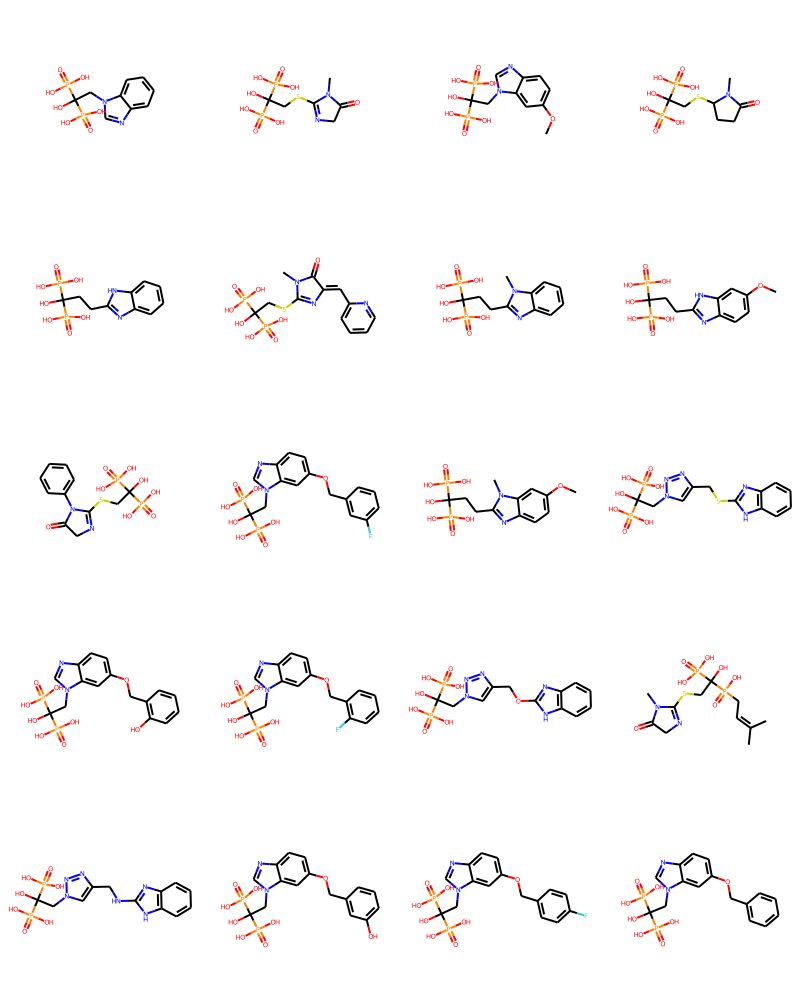

In [14]:
Draw.MolsToGridImage(init_mols_list[:20], molsPerRow=4)

In [15]:
def get_new_smiles(mol):
    randomized_smile_orderings = [randomize_smiles(mol) for _ in range(num_random_samples)]
    selfies_ls = [encoder(x) for x in randomized_smile_orderings]
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)
    smiles_back = [decoder(x) for x in selfies_mut]
    canon_smi_ls = []

    for item in smiles_back:
        mol, smi_canon, did_convert = sanitize_smiles(item)
        if mol == None or smi_canon == '' or did_convert == False:
            raise Exception('Invalid smile string found')
        canon_smi_ls.append(smi_canon)
    canon_smi_ls = list(set(canon_smi_ls))

    return canon_smi_ls

In [16]:
num_random_samples = 5 # количество неканонических SMILES строк, к которым применяются операции мутации
num_mutations = 1 # количество вызовов функции мутации

In [17]:
smiles_0 = df['smiles'][1]

In [19]:
mol_0 = Chem.MolFromSmiles(smiles_0)
get_new_smiles(mol_0)

['N[SH]1(CCC(O)(P(=O)(O)O)P(=O)(O)O)=NCC1=O',
 'CN1C(=O)CN=C1SC(C)(P(=O)(O)O)P(=O)(O)O',
 'CN1C(=O)CN=C1SC(O)(P(O)O)P(=O)(O)O',
 'CN1C(=O)CN=C1SCC(OP(=O)(O)OO)P(O)#[P+]=O',
 'CNOC(SCC(C)(O[PH](=O)O)P(=O)(O)O)N(C)C=O']

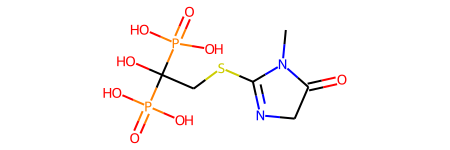

In [20]:
mol_0

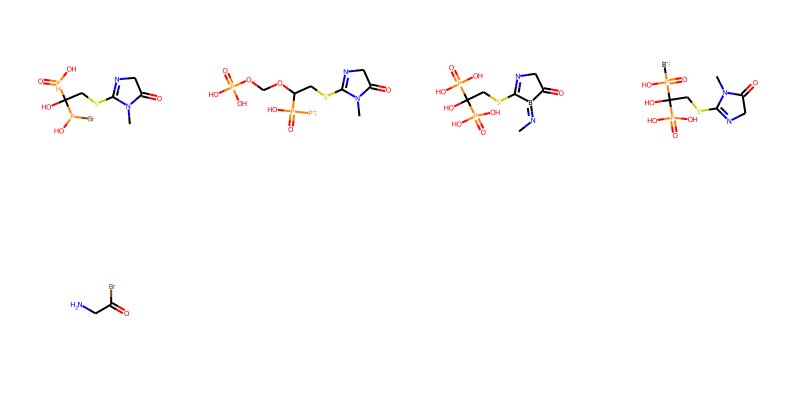

In [21]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in get_new_smiles(mol_0)], molsPerRow=4)

In [22]:
%%timeit
get_new_smiles(mol_0)

5.1 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
import sys
sys.path.append('../')

from scorers.sascorer import calculateScore as MolSAS
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.Descriptors import ExactMolWt
def MolCycleScore(mol):
    cycle_list = mol.GetRingInfo().AtomRings()
    largets_ring_size = max([len(size) for size in cycle_list]) if cycle_list else 0
    cycle_score = max(largets_ring_size - 6, 0)
    return cycle_score

fpps_reg = load('../models/fpps_reg.joblib')
mcf_reg = load('../models/mcf7_reg.joblib')
pc_reg = load('../models/pc3_reg.joblib')

def get_ic_50(smiles):
    try:
        df_clust = get_clust_df(pd.DataFrame([smiles], columns=['smiles']), fpps_good)
        pre = fpps_reg.predict(df_clust[fpps_reg.feature_names_in_])
        return pre.item()
    except:
        return 10

def get_ic_50_pc(smiles):
    try:
        df_clust = get_clust_df(pd.DataFrame([smiles], columns=['smiles']), pc3_good)
        pre = pc_reg.predict(df_clust[pc_reg.feature_names_in_])
        return pre.item()
    except:
        return 10

def get_ic_50_mc(smiles):
    try:
        df_clust = get_clust_df(pd.DataFrame([smiles], columns=['smiles']), mcf7_good)
        pre = mcf_reg.predict(df_clust[mcf_reg.feature_names_in_])
        return pre.item()
    except:
        return 10
    
def struct_loss(smiles):
    patt = Chem.MolFromSmarts('C(P(O)(O)=O)(P(O)(O)=O)')
    return Chem.MolFromSmarts(smiles).HasSubstructMatch(patt) * 5

def get_penalized_ic50(smiles):
    mol = Chem.MolFromSmiles(smiles)
    score = -get_ic_50(smiles) - MolSAS(mol) - MolCycleScore(mol) + struct_loss(smiles) - 1.2*get_ic_50_pc(smiles) - 1.2*get_ic_50_mc(smiles)  
    return score

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or i

maximum penalized ic50: -25.32



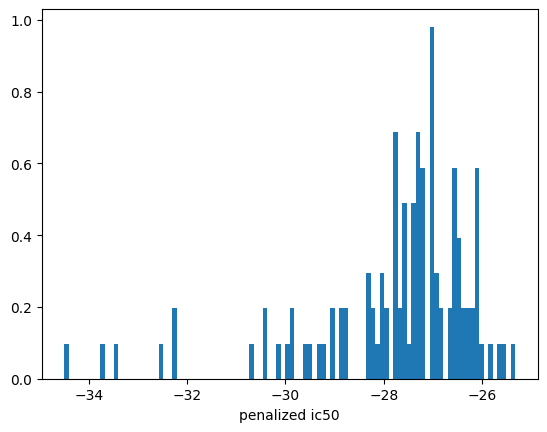

In [35]:
from matplotlib import pyplot as plt
with Pool(32) as p:
    print(f'maximum penalized ic50: {round(np.max(list(p.map(get_penalized_ic50, init_smiles_list))), 2)}\n')
    
with Pool(32) as p:
    plt.hist(list(p.map(get_penalized_ic50, init_smiles_list)), bins=100, density=True)

plt.xlabel('penalized ic50')

plt.show()

In [36]:
num_generations = 10

In [37]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [38]:
from PIL import Image

generation #2
maximum penalized ic50: -24.65



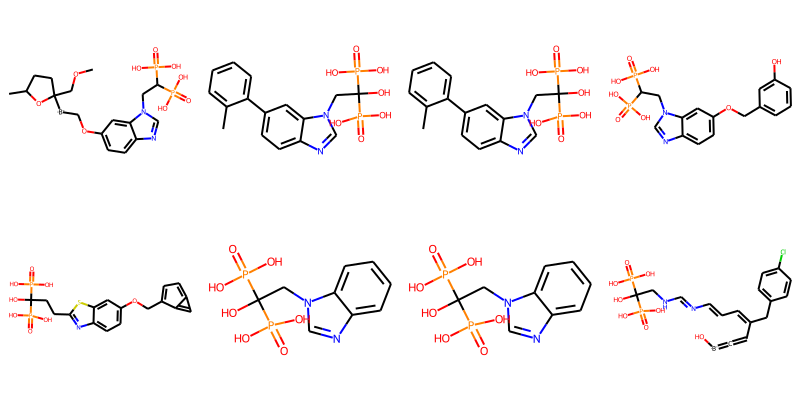

[7.47, 6.95, 6.95, 6.6]
[7.35, 5.37, 5.37, 7.64]
generation #3
maximum penalized ic50: -24.47



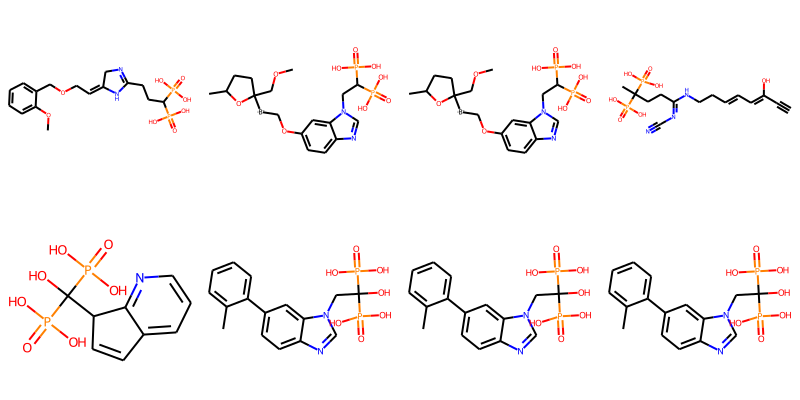

[7.25, 7.47, 7.47, 7.66]
[5.68, 6.95, 6.95, 6.95]
generation #4
maximum penalized ic50: -23.15



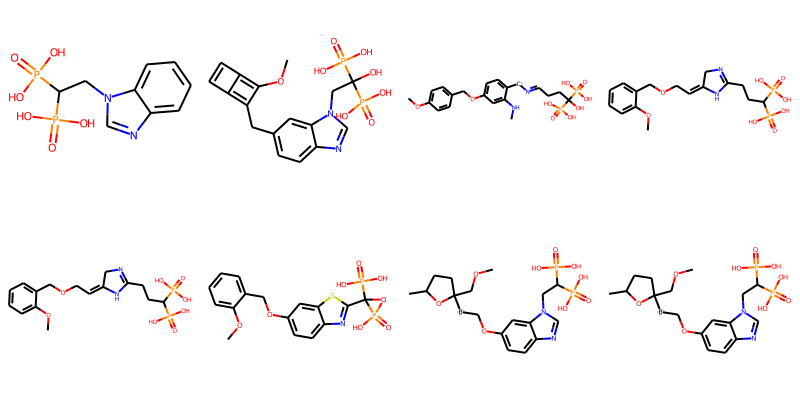

[3.0, 7.39, 7.64, 7.25]
[7.25, 7.6, 7.47, 7.47]
generation #5
maximum penalized ic50: -23.15



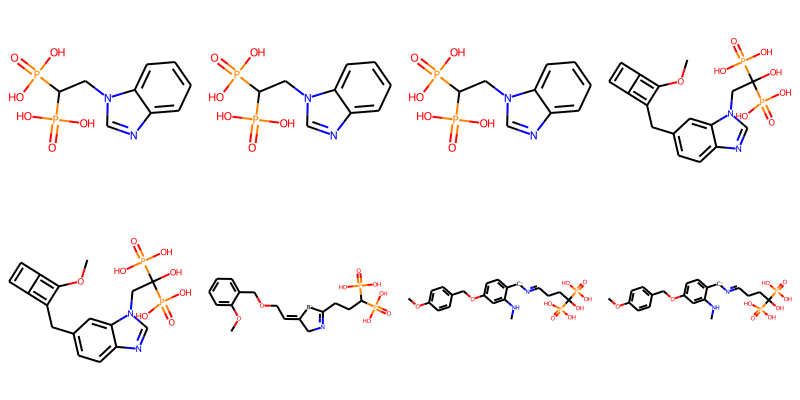

[3.0, 3.0, 3.0, 7.39]
[7.39, 7.34, 7.64, 7.64]
generation #6
maximum penalized ic50: -22.63



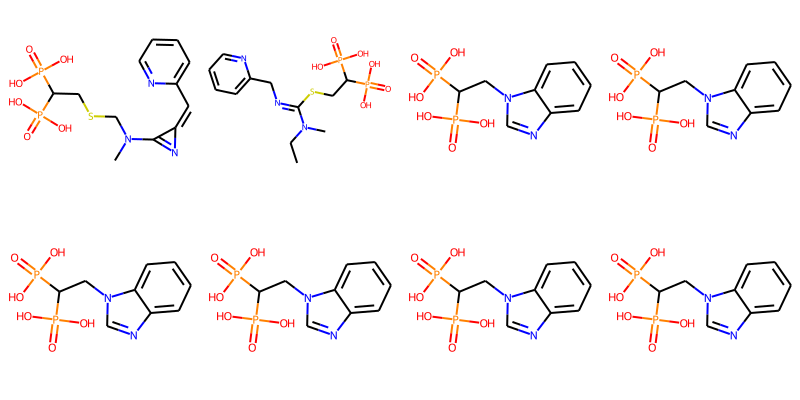

[6.76, 6.67, 3.0, 3.0]
[3.0, 3.0, 3.0, 3.0]
generation #7
maximum penalized ic50: -22.63



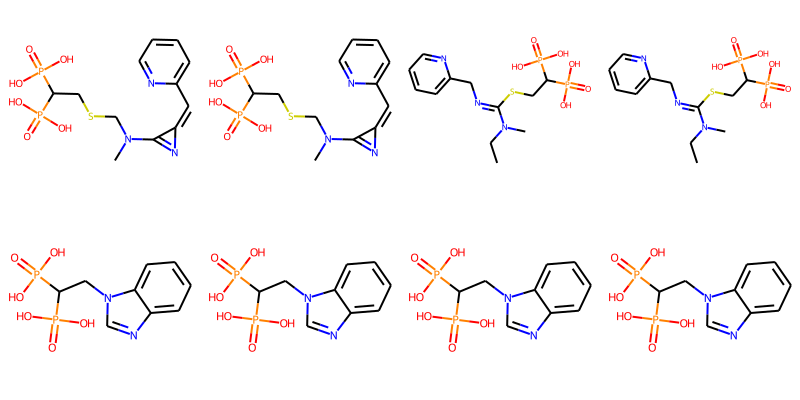

[6.76, 6.76, 6.67, 6.67]
[3.0, 3.0, 3.0, 3.0]
generation #8
maximum penalized ic50: -22.04



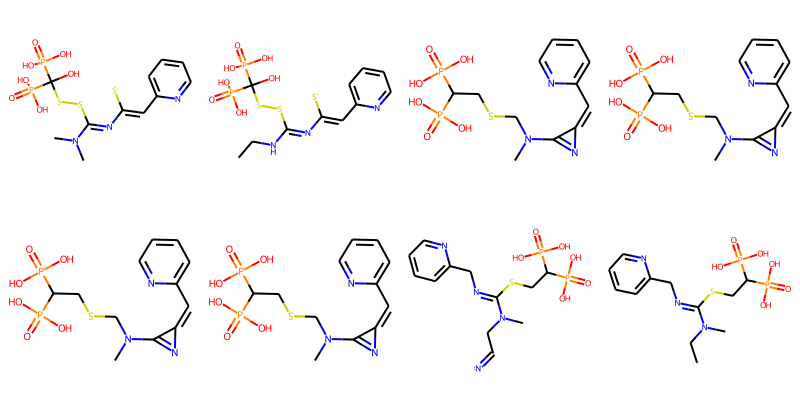

[7.26, 7.23, 6.76, 6.76]
[6.76, 6.76, 6.81, 6.67]
generation #9
maximum penalized ic50: -22.04



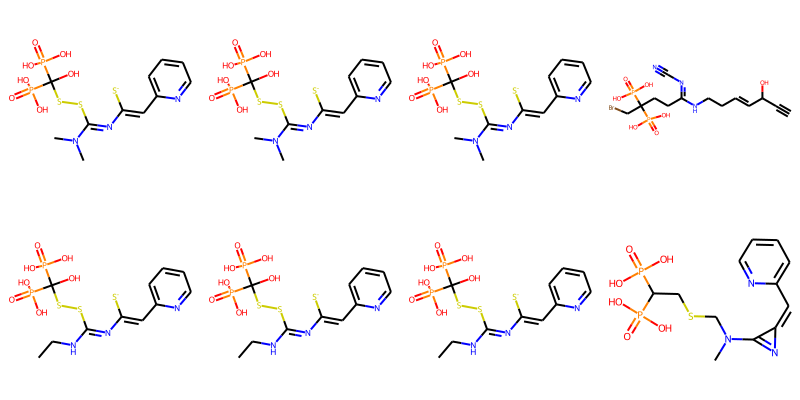

[7.26, 7.26, 7.26, 7.67]
[7.23, 7.23, 7.23, 6.76]
generation #10
maximum penalized ic50: -22.04



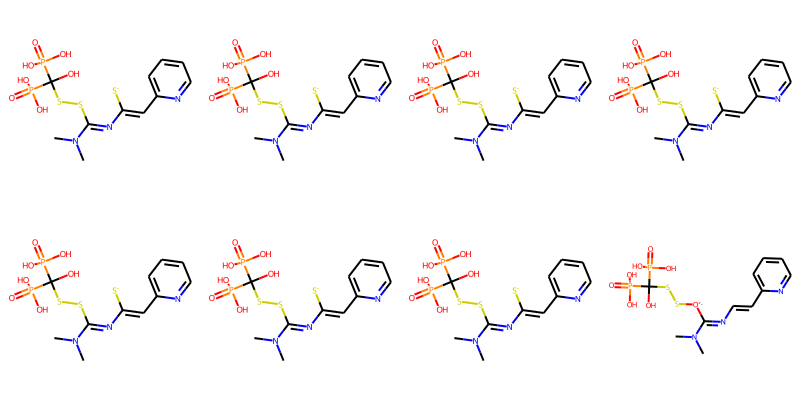

[7.26, 7.26, 7.26, 7.26]
[7.26, 7.26, 7.26, 7.27]


In [ ]:
smiles_list = []
smiles_list_temp = init_smiles_list.copy()
    
for i in range(num_generations):
    for smiles in smiles_list_temp:
        mol = Chem.MolFromSmiles(smiles)
        smiles_list.extend(get_new_smiles(mol))
    smiles_list = smiles_list + smiles_list_temp

    with Pool(32) as p:
        score_list = np.array(list(p.map(get_penalized_ic50, smiles_list)))

    max_indices = score_list.argsort()[-1000:][::-1].tolist()

    top_smiles = [smiles_list[i] for i in max_indices[:8]]
    smiles_list = [smiles_list[i] for i in max_indices]

    smiles_list_temp = smiles_list.copy()
    print(f'generation #{i+1}')
    print(f'maximum penalized ic50: {round(np.max(score_list), 2)}\n')
    
    imgs = [rdkit.Chem.Draw.MolToImage(Chem.MolFromSmiles(smiles), size=(200, 200)) for smiles in top_smiles]
    with Pool(32) as p:
        top_score_list = np.array(list(p.map(get_ic_50, top_smiles)))
    top_score_list = [round(s, 2) for s in top_score_list.tolist()]
    image_grid(imgs, 2, 4).show()
    print(top_score_list[:4])
    print(top_score_list[4:])
    plt.show()

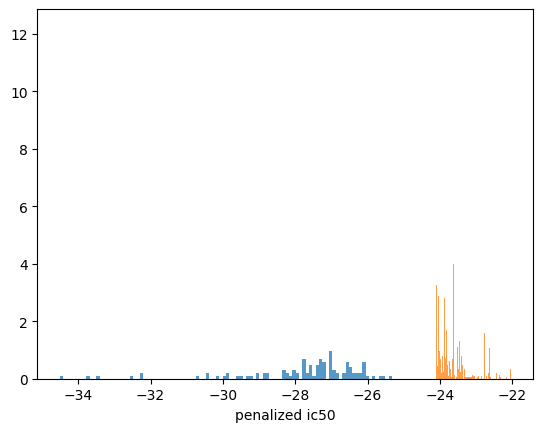

In [40]:
with Pool(32) as p:
    plt.hist(list(p.map(get_penalized_ic50, init_smiles_list)), bins=100, density=True, alpha=0.75)

with Pool(32) as p:
    plt.hist(list(p.map(get_penalized_ic50, smiles_list)), bins=100, density=True, alpha=0.75)

plt.xlabel('penalized ic50')
plt.show()

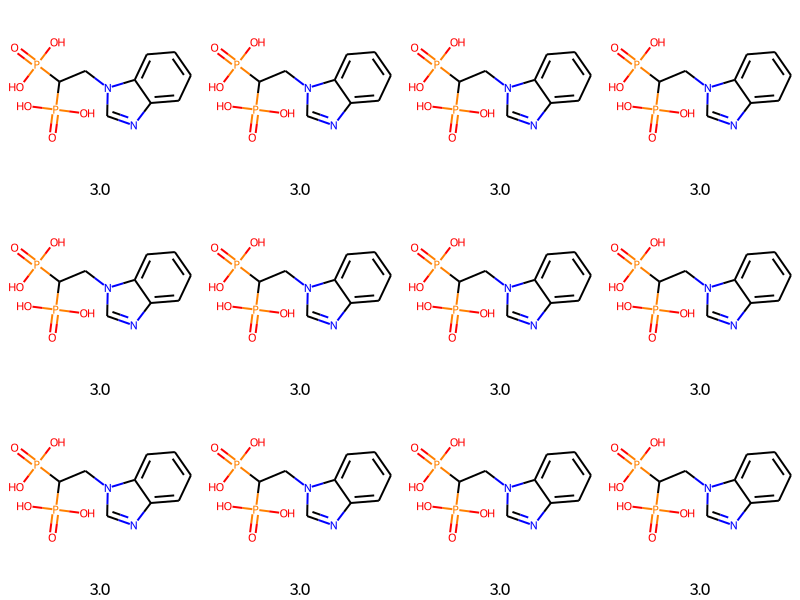

In [41]:
with Pool(32) as p:
    score_list = np.array(list(p.map(get_ic_50, smiles_list)))

max_indices = score_list.argsort()[:12].tolist()
top_molecules = [Chem.MolFromSmiles(smiles_list[i]) for i in max_indices]
top_score_list = [round(s, 2) for s in score_list[max_indices].tolist()]

Draw.MolsToGridImage(top_molecules, molsPerRow=4, legends=list(map(str, top_score_list)))

In [42]:
from rdkit.Chem import PandasTools

In [43]:
df = pd.DataFrame()

In [44]:
df['mol'] = [Chem.MolFromSmiles(x) for _, x in enumerate(smiles_list)]
df['fpps'] = score_list
df['smiles'] = smiles_list

In [45]:
with Pool(32) as p:
    df['mcf7'] = np.array(list(p.map(get_ic_50_mc, smiles_list)))
    df['pc3'] = np.array(list(p.map(get_ic_50_pc, smiles_list)))

In [46]:
df = df.drop_duplicates(subset=['smiles']).sort_values(by=['fpps'])

In [47]:
df

,mol,fpps,smiles,mcf7,pc3
107,"<img data-content=""rdkit/molecule"" src=""data:i...",3.001015,O=P(O)(O)C(Cn1cnc2ccccc21)P(=O)(O)O,11.084649,7.537004
708,"<img data-content=""rdkit/molecule"" src=""data:i...",5.899077,O=P(O)(O)C(SC=NCc1ccccn1)P(=O)(O)O,8.271183,7.692190
807,"<img data-content=""rdkit/molecule"" src=""data:i...",6.172732,O=P(O)(O)C(Cn1cnc2ccc(-c3ccccc3F)cc21)P(=O)(O)O,9.407492,7.259560
644,"<img data-content=""rdkit/molecule"" src=""data:i...",6.185566,O=P(O)(O)C(CNC=CCCC=CCF)P(=O)(O)O,7.535276,7.976368
102,"<img data-content=""rdkit/molecule"" src=""data:i...",6.350060,CCNC(=NCc1ccccn1)SC(P(=O)(O)O)P(=O)(O)O,7.659119,7.575265
...,...,...,...,...,...
356,"<img data-content=""rdkit/molecule"" src=""data:i...",7.665777,C#CC(O)C=CCNC(CCC(CBr)(P(=O)(O)O)P(=O)(O)O)=NC#N,5.305488,7.702297
393,"<img data-content=""rdkit/molecule"" src=""data:i...",7.665896,C#CC(O)=C[C+]=CCCNC(CCC(Cl)(P(=O)(O)O)P(=O)(O)...,5.784276,7.165576
954,"<img data-content=""rdkit/molecule"" src=""data:i...",7.666001,C#CC(O)=CC=CCCNC(CCC(CBr)(P(=O)(O)O)P(=O)(O)O)...,6.341543,7.704945
9,"<img data-content=""rdkit/molecule"" src=""data:i...",7.666004,C#CC(O)C=CCCNC(CCC(CBr)(P(=O)(O)O)P(=O)(O)O)=NC#N,4.851259,7.559436


In [48]:
train_set = pd.read_csv('../data/clean_data/fpps_cl.csv')

In [49]:
dup = []
for el in df['smiles']:
    dup.append(el in train_set['smiles'].to_list())

In [50]:
df['dup'] = dup
df['dup'] = df['dup'].astype(int)

In [51]:
df

,mol,fpps,smiles,mcf7,pc3,dup
107,"<img data-content=""rdkit/molecule"" src=""data:i...",3.001015,O=P(O)(O)C(Cn1cnc2ccccc21)P(=O)(O)O,11.084649,7.537004,1
708,"<img data-content=""rdkit/molecule"" src=""data:i...",5.899077,O=P(O)(O)C(SC=NCc1ccccn1)P(=O)(O)O,8.271183,7.692190,0
807,"<img data-content=""rdkit/molecule"" src=""data:i...",6.172732,O=P(O)(O)C(Cn1cnc2ccc(-c3ccccc3F)cc21)P(=O)(O)O,9.407492,7.259560,0
644,"<img data-content=""rdkit/molecule"" src=""data:i...",6.185566,O=P(O)(O)C(CNC=CCCC=CCF)P(=O)(O)O,7.535276,7.976368,0
102,"<img data-content=""rdkit/molecule"" src=""data:i...",6.350060,CCNC(=NCc1ccccn1)SC(P(=O)(O)O)P(=O)(O)O,7.659119,7.575265,0
...,...,...,...,...,...,...
356,"<img data-content=""rdkit/molecule"" src=""data:i...",7.665777,C#CC(O)C=CCNC(CCC(CBr)(P(=O)(O)O)P(=O)(O)O)=NC#N,5.305488,7.702297,0
393,"<img data-content=""rdkit/molecule"" src=""data:i...",7.665896,C#CC(O)=C[C+]=CCCNC(CCC(Cl)(P(=O)(O)O)P(=O)(O)...,5.784276,7.165576,0
954,"<img data-content=""rdkit/molecule"" src=""data:i...",7.666001,C#CC(O)=CC=CCCNC(CCC(CBr)(P(=O)(O)O)P(=O)(O)O)...,6.341543,7.704945,0
9,"<img data-content=""rdkit/molecule"" src=""data:i...",7.666004,C#CC(O)C=CCCNC(CCC(CBr)(P(=O)(O)O)P(=O)(O)O)=NC#N,4.851259,7.559436,0


In [52]:
PandasTools.SaveXlsxFromFrame(df, '../result_data/all_gen_1_2.xlsx', molCol='mol', size=(150,150))